## A Rough Skeleton of Working Draft
---------------------------------------------------------------------------------------------------------


### Table of Contents:
1. Sypnosis
    - Research Question
    - Summary
<p></p>
2. Our Data Set 
    - Packages Used
    - Loading and Cleansing
    
---------------------------------------------------------------------------------------------------------

### 1.) Sypnosis: 

##### Research Question:
How can an author increase engagement from users on Facebook and can we predict the success of a post using insights from an author's page?


##### Overview:
(description)

---------------------------------------------------------------------------------------------------------

### 2.) Dataset

##### Packages Used:

In [183]:
install.packages("caTools")
library(caTools)

library(tidyverse)
library(repr)
library(tidymodels)
library(MASS)
options(repr.matrix.max.rows = 8)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



##### Facebook Data set:
(description)

In [184]:
facebook <- read_csv2("data/dataset_Facebook.csv")
facebook

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,2,1,5,8,0,3480,6229,537,508,687,3961,2104,301,0,53,22,75
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119


In [185]:
# Replacing specified columns to categorical factors
cols <- c("Type", "Category", "Post Month", "Paid", "Post Weekday", "Post Hour")
facebook[cols] <- lapply(facebook[cols], as.factor)

# Renaming column headers without spaces
facebook_colname_fix <- facebook

facebook_col_name_vec <- gsub(" ", "_", colnames(facebook))
colnames(facebook) <- facebook_col_name_vec

glimpse(facebook)



Rows: 500
Columns: 19
$ Page_total_likes                                                    <dbl> 1…
$ Type                                                                <fct> P…
$ Category                                                            <fct> 2…
$ Post_Month                                                          <fct> 1…
$ Post_Weekday                                                        <fct> 4…
$ Post_Hour                                                           <fct> 3…
$ Paid                                                                <fct> 0…
$ Lifetime_Post_Total_Reach                                           <dbl> 2…
$ Lifetime_Post_Total_Impressions                                     <dbl> 5…
$ Lifetime_Engaged_Users                                              <dbl> 1…
$ Lifetime_Post_Consumers                                             <dbl> 1…
$ Lifetime_Post_Consumptions                                          <dbl> 1…
$ Lifetime_Post_Impressions_by

### Let us select only the data values relevant to our case scenario

We want to explain the best type of post possible and thus we should first explore the relationship between the metrics produced by a post and the individual post type. The following key performance indicators describe a post's success:
- comments
- likes
- shares
- total interactions (summation of the 3 observations above)

We will consider removing data points that are missing values if enough data is present. 

In [254]:
facebook_clean <- dplyr::select(facebook, Type, comment,
                                like, share, Total_Interactions,
                                Paid, Lifetime_Post_Total_Impressions) %>% na.omit(df)

facebook_clean_unpaid <- facebook_clean %>% filter(Paid == 0)
facebook_clean_paid <- facebook_clean %>% filter(Paid == 1)


## Compartmentalization of our data into Training, Validation, and Testing Sets 



We have 500 data points collected, of which me must remove observations with NA. We will first filter our data into paid / unpaid data frames and see if there is enough data to persist. After which we will explore the various summary statistics within each group.

-----
**METHOD 1: Training and Testing set**
<br>
Testing set will be 20% of data collected
Validation set will be 10% of data collected
Training data set be 70% of data collected

**METHOD 2: Cross-validation technique**
<br>
let us split our data into 4 total groups with a 1:5 ratio of testing and training data. 
(~25 points tested, 100 points for training)

In [257]:
# Preliminary Steps
# Method 1:
set.seed(99)
partitionTrain = 0.8
ratioTrainValidation = 7/8

#### Total Posts:

In [265]:
# 80/20 ratio TrainingSet:TestingSet
split <- sample.split(facebook_clean$like, SplitRatio = partitionTrain)
train_val_data = subset(facebook_clean, split == TRUE)
test_set = subset(facebook_clean, split == FALSE)

split <- sample.split(train_val_data$like, SplitRatio = ratioTrainValidation)
train_set = subset(train_val_data, split == TRUE)
val_set = subset(train_val_data, split == FALSE)
glimpse(train_set)

Rows: 346
Columns: 7
$ Type                            <fct> Status, Photo, Photo, Photo, Status, …
$ comment                         <dbl> 5, 0, 58, 19, 1, 3, 0, 0, 0, 4, 15, 4…
$ like                            <dbl> 130, 66, 1572, 325, 152, 113, 233, 88…
$ share                           <dbl> 29, 14, 147, 49, 33, 26, 19, 18, 14, …
$ Total_Interactions              <dbl> 164, 80, 1777, 393, 186, 142, 252, 10…
$ Paid                            <fct> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0…
$ Lifetime_Post_Total_Impressions <dbl> 19057, 4373, 87991, 13594, 20849, 866…


#### Unpaid Posts:

In [266]:
set.seed(99)

split <- sample.split(facebook_clean_unpaid$like, SplitRatio = partitionTrain)
train_val_data_unpaid = subset(facebook_clean_unpaid, split == TRUE)
test_set_unpaid = subset(facebook_clean_unpaid, split == FALSE)

split <- sample.split(train_val_data_unpaid$like, SplitRatio = ratioTrainValidation)
train_set_unpaid = subset(train_val_data_unpaid, split == TRUE)
val_set_unpaid = subset(train_val_data_unpaid, split == FALSE)

glimpse(train_set_unpaid)

Rows: 248
Columns: 7
$ Type                            <fct> Photo, Status, Photo, Status, Photo, …
$ comment                         <dbl> 4, 5, 0, 1, 3, 0, 0, 0, 5, 2, 4, 0, 3…
$ like                            <dbl> 79, 130, 66, 152, 113, 233, 88, 90, 1…
$ share                           <dbl> 17, 29, 14, 33, 26, 19, 18, 14, 10, 1…
$ Total_Interactions              <dbl> 100, 164, 80, 186, 142, 252, 106, 104…
$ Paid                            <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Lifetime_Post_Total_Impressions <dbl> 5091, 19057, 4373, 20849, 8668, 42334…


#### Paid:

In [267]:
set.seed(99)

partitionTrain = 0.8
ratioTrainValidation = 7/8

split <- sample.split(facebook_clean_paid$like, SplitRatio = partitionTrain)
train_val_data_paid = subset(facebook_clean_paid, split == TRUE)
test_set_paid = subset(facebook_clean_paid, split == FALSE)

split <- sample.split(train_val_data_paid$like, SplitRatio = ratioTrainValidation)
train_set_paid = subset(train_val_data_paid, split == TRUE)
val_set_paid = subset(train_val_data_paid, split == FALSE)

glimpse(train_set_paid)

Rows: 97
Columns: 7
$ Type                            <fct> Photo, Photo, Photo, Photo, Link, Lin…
$ comment                         <dbl> 58, 3, 15, 16, 6, 7, 4, 24, 2, 8, 8, …
$ like                            <dbl> 1572, 249, 678, 76, 187, 29, 57, 285,…
$ share                           <dbl> 147, 27, 20, 8, 18, 10, 10, 28, 14, 1…
$ Total_Interactions              <dbl> 1777, 279, 713, 100, 211, 46, 71, 337…
$ Paid                            <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ Lifetime_Post_Total_Impressions <dbl> 87991, 19479, 111785, 28663, 28438, 4…


### Training Data Summaries
Each Table includes:
- Number of observations of each type
- Mean and Median of key metrics in each post type


#### Summary of Paid Posts:

In [250]:
summ_train_df <- training_set %>% group_by(Type) %>%  summarise(
    count = n(),
    mean_comment = mean(comment), 
    median_comment = median(comment), 
    mean_like = mean(like),
    median_like = median(like),
    mean_Total_Interactions = mean(Total_Interactions),
    median_Total_Interactions = median(Total_Interactions),
    mean_share = mean(share),
    median_share = median(share),
)
summ_train_df

`summarise()` ungrouping output (override with `.groups` argument)



Type,count,mean_comment,median_comment,mean_like,median_like,mean_Total_Interactions,median_Total_Interactions,mean_share,median_share
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Link,7,3.285714,2,67.57143,32.0,88.14286,49.0,17.28571,15
Photo,214,6.434579,2,160.21963,91.5,190.77103,114.5,24.11682,18
Status,26,8.615385,4,145.23077,129.5,179.92308,165.0,26.07692,26
Video,1,23.000000,23,204.00000,204.0,271.00000,271.0,44.00000,44


#### Summary of Unpaid Posts:

In [251]:
summ_train_df_paid <- train_set_paid %>% group_by(Type) %>%  summarise(
    count = n(),
    mean_comment = mean(comment), 
    median_comment = median(comment), 
    mean_like = mean(like),
    median_like = median(like),
    mean_Total_Interactions = mean(Total_Interactions),
    median_Total_Interactions = median(Total_Interactions),
    mean_share = mean(share),
    median_share = median(share),
    
)
summ_train_df_paid

`summarise()` ungrouping output (override with `.groups` argument)



Type,count,mean_comment,median_comment,mean_like,median_like,mean_Total_Interactions,median_Total_Interactions,mean_share,median_share
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Link,6,4.000000,5,56.66667,33.5,71.0000,51,10.33333,10.5
Photo,82,7.317073,4,202.14634,127.0,235.2683,155,25.80488,19.0
Status,6,13.166667,14,281.16667,274.0,353.8333,339,59.50000,52.5
Video,3,12.333333,17,276.33333,315.0,346.6667,409,58.00000,76.0


---------------------------------------------------------------------------------------------------------

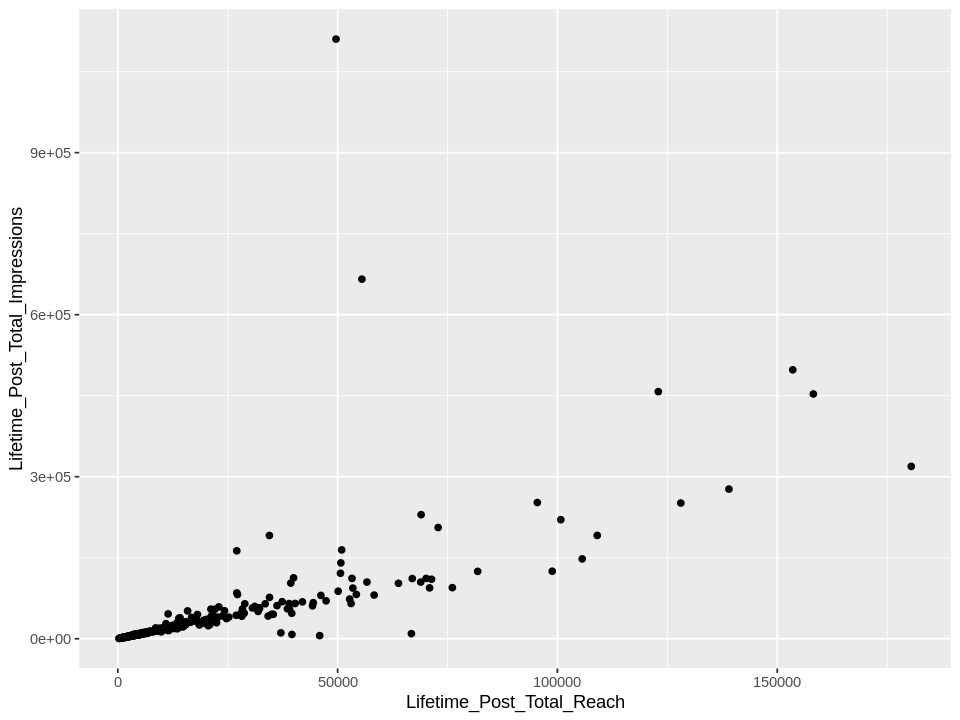

In [217]:
test_plot <- facebook %>% ggplot(aes(x = Lifetime_Post_Total_Reach, y = Lifetime_Post_Total_Impressions)) + geom_point()
test_plot

In [218]:
likes_by_type <- facebook %>%
group_by(Type) %>%
summarise(total_likes = sum(like, na.rm = TRUE))

likes_by_type

`summarise()` ungrouping output (override with `.groups` argument)



Type,total_likes
<fct>,<dbl>
Link,1613
Photo,77610
Status,7952
Video,1620


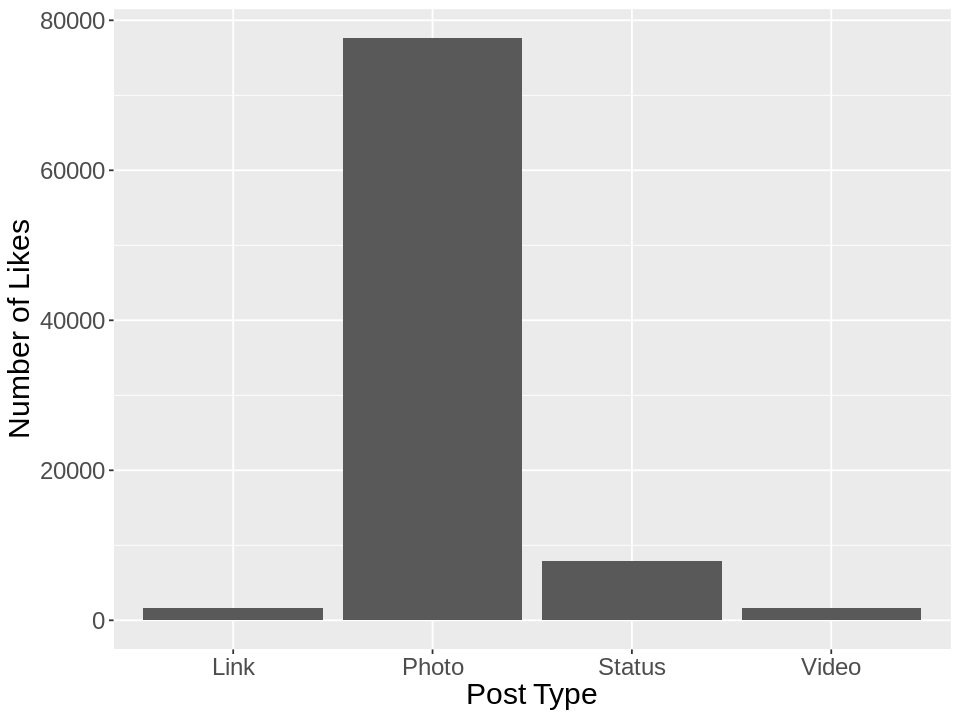

In [219]:
options(repr.plot.width = 8, repr.plot.height = 6) 

likes_bar <- ggplot(likes_by_type, aes(x = Type, y = total_likes)) +
geom_bar(stat = "identity") +
labs(x = "Post Type", y = "Number of Likes") +
theme(text = element_text(size = 18)) 

likes_bar